In [1]:
from MALBuddy import MALBuddy
import pandas as pd
import os
import re
import numpy as np

client_info_filepath = "client_info.json"
token_filepath = "token.json"

In [2]:
buddy = MALBuddy(client_info_filepath, token_filepath)


In [3]:
def genre_from_dict_list(genre_list):
    genres = []
    for entry in genre_list:
        genres.append(entry['name'])
    return genres

In [4]:
user = 'chocopieeater'
anime_list = buddy.get_anime_list(user)
anime_list.head()

,id,title,main_picture,status,score,num_episodes_watched,is_rewatching,updated_at,finish_date,start_date
0,41457,86,{'medium': 'https://api-cdn.myanimelist.net/im...,dropped,0,0,False,2021-05-02T00:36:51+00:00,NaN,NaN
1,22199,Akame ga Kill!,{'medium': 'https://api-cdn.myanimelist.net/im...,completed,8,24,False,2019-02-26T07:05:44+00:00,NaN,NaN
2,41433,Akudama Drive,{'medium': 'https://api-cdn.myanimelist.net/im...,dropped,0,7,False,2020-12-28T21:14:38+00:00,NaN,NaN
3,22729,Aldnoah.Zero,{'medium': 'https://api-cdn.myanimelist.net/im...,completed,6,12,False,2018-08-07T02:05:12+00:00,NaN,NaN
4,27655,Aldnoah.Zero 2nd Season,{'medium': 'https://api-cdn.myanimelist.net/im...,dropped,0,11,False,2018-08-07T01:31:22+00:00,NaN,NaN


In [5]:
id_title = zip(anime_list['id'].to_numpy(),anime_list['title'].to_numpy())
for id_, title in id_title:
    buddy.generate_and_write_ratings(id_, title, num_pages=5)
    print()

Successfully loaded pages: : 1, 

KeyboardInterrupt: 

In [ ]:
buddy.load_ratings('86')

In [ ]:
from datetime import datetime
start = datetime.now()
try:
    id_title = zip(anime_list['id'].to_numpy(),anime_list['title'].to_numpy())
    for id_, title in id_title:
        buddy.generate_and_write_users(id_, title, num_pages=5)
except:
    print("Something Went Wrong")
    
elapsed = datetime.now() - start
print(f"Total time taken: {elapsed}")


In [305]:
l = buddy.get_anime_list('chocopieeater')[['id','score']]
l[l['score'] != 0]

,id,score
1,22199,8
3,22729,6
5,6547,8
6,24833,8
8,9919,7
...,...,...
228,37779,9
229,39617,4
230,32615,8
232,37055,8


In [469]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

In [470]:
def build_rating_sparse_tensor(ratings_df):
    indices = ratings_df[['user_id', 'movie_id']].values
    values = ratings_df['score'].values
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [471]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
    axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [472]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    """
    Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
    Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
    """
    predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [473]:
# @title CFModel helper class (run this cell)
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
              tf.variables_initializer(opt.variables()),
              tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

          # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
        return results

In [474]:
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [475]:
#@title Solution
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    """
    Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
    model: a CFModel.
    """
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    print(A_train.shape)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    print(train_loss)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "user_id": U,
      "movie_id": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [488]:
# loads users from webscraped jsons
#buddy.make_users_to_load()

True

In [587]:
unloaded_users

120    Isotope_U235
121     AkariNaKari
122          hoakxo
123         Shainux
124         Anorak6
           ...     
742    Little_Kaiju
743      9_liebe_xd
744     eat_magnets
739          mrtrob
741       Zoltar565
Length: 566, dtype: object

In [584]:
existing_users

,movie_id,score,user
0,31964,10,Sade04
1,33486,10,Sade04
2,36456,10,Sade04
3,38408,10,Sade04
4,41587,10,Sade04
...,...,...,...
16194,39607,10,Spike69_69
16195,22319,8,Spike69_69
16196,37799,6,Spike69_69
16197,40784,3,Spike69_69


In [585]:
#generate new user animelists
from datetime import datetime
start = datetime.now()
user_df = pd.DataFrame()
users_to_load = buddy.get_unloaded_users()
existing_users = pd.DataFrame(buddy.read_json('user_ratings.json'))
unloaded_users = users_to_load[pd.Series(users_to_load).apply(lambda x: x not in existing_users['user'].unique())]
cur_id = 0

num_to_load = 20

print(f"Generating {num_to_load} new anime lists")
for x in range(num_to_load):
    try:
        user = unloaded_users[x]
        print(f"Generating anime list for {user}")
        user_mal = buddy.get_anime_list(user)
        if type(user_mal) != str:
            user_mal = user_mal[['id','score']] # retrieve anime id and score
            user_mal = user_mal[user_mal['score'] != 0] #drop unrated shows
            user_mal['user'] = user 
            if(len(user_mal) > 0):
                user_df = pd.concat([user_df, user_mal])
                cur_id += 1
            else:
                print(f"removing {user}")
                buddy.remove_from_user_list(user)
        else:
            print(f"removing {user}")
            buddy.remove_from_user_list(user)
    except:
        print(f"Error loading {user}")
        print(f"removing {user}")
        buddy.remove_from_user_list(user)

elapsed = datetime.now() - start
print(elapsed)

Generating 20 new anime lists
Generating anime list for Isotope_U235
removing Isotope_U235
Generating anime list for AkariNaKari
Generating anime list for hoakxo
Error requesting anime list. Aborting...
Error loading hoakxo
removing hoakxo
Generating anime list for Shainux
Generating anime list for Anorak6
Error requesting anime list. Aborting...
Error loading Anorak6
removing Anorak6
Generating anime list for SK0L
Generating anime list for _loukinho7
Generating anime list for SweetestTraps
Generating anime list for Vojat
Generating anime list for Doomas1211
Generating anime list for mattiagobbo
Generating anime list for _KAGU_
Generating anime list for MacDaddy11
Generating anime list for Tempest8
Generating anime list for vladchanCh
Generating anime list for MrBibbon
Generating anime list for _Ejdm
Generating anime list for Lilitth
Generating anime list for mkent1307
Generating anime list for ss7gohan7
0:00:08.771171


In [588]:
user_df = user_df.rename(columns={'id':'movie_id'})
user_df = user_df.reset_index(drop=True)

In [510]:
#import json
#with open('user_ratings.json', 'r') as file:
#    x = json.load(file)
#    file.close()
#with open('user_ratings.json','w') as file:
#    json.dump(pd.DataFrame(x).drop('user_id',axis=1).to_dict(),file)

In [589]:
user_df

,movie_id,score,user
0,22199,6,AkariNaKari
1,9919,5,AkariNaKari
2,46352,7,AkariNaKari
3,31964,7,AkariNaKari
4,33486,6,AkariNaKari
...,...,...,...
2618,5680,7,ss7gohan7
2619,7791,7,ss7gohan7
2620,16904,7,ss7gohan7
2621,590,6,ss7gohan7


In [590]:
buddy.write_user_df(user_df,'user_ratings.json',append=True)

True

In [643]:
user_df = pd.DataFrame(buddy.read_json('user_ratings.json'))
user_df

,movie_id,score,user
0,31964,10,Sade04
1,33486,10,Sade04
2,36456,10,Sade04
3,38408,10,Sade04
4,41587,10,Sade04
...,...,...,...
20733,5680,7,ss7gohan7
20734,7791,7,ss7gohan7
20735,16904,7,ss7gohan7
20736,590,6,ss7gohan7


In [644]:
user_df['user'].nunique()

157

In [645]:
USER = buddy.get_anime_list('chocopieeater')
USER = USER[['id','score']] # retrieve anime id and score
USER = USER[USER['score'] != 0] #drop unrated shows
USER['user'] = 'chocopieeater'
USER = USER.rename(columns={'id':'movie_id'})

user_df = pd.concat([user_df, USER])
user_df = user_df.reset_index(drop=True)



In [646]:
user_df['user'].unique()

array(['Sade04', 'R3LLA', 'CAKEintheLAKE', 'formlesz', 'Todoroki19',
       'Nyroc2100', 'MaikeruAT', 'meekaya', 'Geralt_of_Bals', 'Jester900',
       'VioletKite', 'Bukkuros', 'BananaKuma', 'Otaku-with-brain',
       'Samotniczka', 'EmiFukira', 'iluvcatslol', 'Kona-chaan',
       'Cirox789', 'Rimuru_Exorcist7', 'Anima-Girl', 'Lirvothe2',
       'NineIX', 'Husala005', 'Lancynical', 'stehino', 'MaleqIshak02',
       'Vashley', 'KacadX', 'nullmega', 'DoomedMarine', 'gb10110',
       'hangessexymanbun', 'DRachel', 'Vic5', 'Zantaros', 'bj851',
       'zatheauz', '10brand', 'marmaruri', 'KanaoTsuyurii',
       'sneakyninja9', 'Chikarameiyo24', 'Rahim10', 'Nindude', 'djdew54',
       'Schiffinor', 'Santico14', 'Miccc_Weeb', 'katie_chi', 'narumikya',
       'cindylouwho69', 'jarol6432', 'FabriF', 'underwit', 'JustImax',
       'Ignisz', 'Triblim', 'Rockbote', 'mahoshojo96', 'MoarCowbell',
       'notyourwaifuu', 'AlexDSSKLA', 'Agonistic', 'Kamurph23',
       'VaneMora', 'Katamiiiiii', 'Blanc4

In [647]:
users = pd.DataFrame(user_df['user'].drop_duplicates()).reset_index(drop=True).reset_index().rename({'index':'user_id'},axis=1)

In [648]:
users

,user_id,user
0,0,Sade04
1,1,R3LLA
2,2,CAKEintheLAKE
3,3,formlesz
4,4,Todoroki19
...,...,...
153,153,_Ejdm
154,154,Lilitth
155,155,mkent1307
156,156,ss7gohan7


In [649]:
# load  movies from json
movies = pd.DataFrame(buddy.read_json('animes.json'))

In [650]:
movies_needed = user_df[user_df.apply(lambda x: x['movie_id'] not in movies['id'].unique(),axis=1)]['movie_id'].unique()
print(f"movies needed: {len(movies_needed)}")

movies needed: 0


In [651]:
from datetime import datetime
start = datetime.now()

if(len(movies_needed) > 0):
    print(f"Downloading {len(movies_needed)} needed movies")
    movies = buddy.load_anime_details(movies_needed)
else:
    print("No movies to download")

elapsed = datetime.now() - start
print(elapsed)

No movies to download
0:00:00


In [652]:
buddy.write_anime_df(movies,'animes.json',append=True)

True

In [653]:
movies = pd.DataFrame(buddy.read_json('animes.json'))

In [654]:
movies_needed = user_df[user_df.apply(lambda x: x['movie_id'] not in movies['id'].unique(),axis=1)]['movie_id'].unique()
if len(movies_needed) > 0:
    print(f"Error! {len(movies_needed)} movies not loaded")

In [655]:
from sklearn.preprocessing import MultiLabelBinarizer

In [656]:
mlb = MultiLabelBinarizer()
binarized_data = mlb.fit_transform(movies['genres'].to_list())

In [659]:
mlb.classes_

array(['Action', 'Adventure', 'Avant Garde', 'Boys Love', 'Cars',
       'Comedy', 'Demons', 'Drama', 'Ecchi', 'Erotica', 'Fantasy', 'Game',
       'Girls Love', 'Gourmet', 'Harem', 'Historical', 'Horror', 'Josei',
       'Kids', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shounen', 'Slice of Life',
       'Space', 'Sports', 'Super Power', 'Supernatural', 'Suspense',
       'Vampire'], dtype=object)

In [660]:
genre_binarized = pd.DataFrame(data = binarized_data,columns=mlb.classes_)
#movies1 = pd.concat([movies,genre_binarized], axis=1, join='outer')
#dataframe arent joining correct on the index, so I'm create key columnns from the indices
movies = movies.reset_index().join(genre_binarized.reset_index(),lsuffix='left',rsuffix='right').drop(['indexleft','indexright'],axis=1)

In [661]:
movies

,id,title,main_picture,start_date,end_date,genres,Action,Adventure,Avant Garde,Boys Love,...,Seinen,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Suspense,Vampire
0,22199,Akame ga Kill!,{'medium': 'https://api-cdn.myanimelist.net/im...,2014-07-07,2014-12-15,"[Action, Adventure, Drama, Fantasy, Shounen]",1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,32828,Amaama to Inazuma,{'medium': 'https://api-cdn.myanimelist.net/im...,2016-07-05,2016-09-20,"[Comedy, Gourmet, Seinen, Slice of Life]",0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,269,Bleach,{'medium': 'https://api-cdn.myanimelist.net/im...,2004-10-05,2012-03-27,"[Action, Adventure, Comedy, Shounen, Super Pow...",1,1,0,0,...,0,0,1,0,0,0,1,1,0,0
3,31043,Boku dake ga Inai Machi,{'medium': 'https://api-cdn.myanimelist.net/im...,2016-01-08,2016-03-25,"[Mystery, Psychological, Seinen, Supernatural]",0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,31964,Boku no Hero Academia,{'medium': 'https://api-cdn.myanimelist.net/im...,2016-04-03,2016-06-26,"[Action, Comedy, School, Shounen, Super Power]",1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,40134,Mahoutsukai no Yome: Gakuin-hen,{'medium': 'https://api-cdn.myanimelist.net/im...,2019-03-10,2019-03-10,"[Fantasy, Shounen, Slice of Life]",0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4099,48438,Mahoutsukai no Yome: Nishi no Shounen to Seira...,{'medium': 'https://api-cdn.myanimelist.net/im...,2021-09-10,2022-09-10,"[Fantasy, Shounen, Slice of Life]",0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4100,2000,Roujin Z,{'medium': 'https://api-cdn.myanimelist.net/im...,1991-09-14,1991-09-14,"[Comedy, Drama, Mecha, Sci-Fi]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4101,17409,Sukitte Ii na yo.: Mei and Marshmallow,{'medium': 'https://api-cdn.myanimelist.net/im...,2012-12-26,2013-05-22,"[Romance, School, Shoujo]",0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [662]:
movies['genre'] = movies['genres'].apply(lambda lst: lst[np.random.randint(0,len(lst))] if len(lst) > 0 else 0)


In [663]:
movies_df = movies.reset_index().drop('id',axis=1).rename(columns={'index':'id'})

In [664]:
movies = movies.rename(columns={'id':'movie_id'})

In [665]:
movies = movies.set_index('movie_id')

In [668]:
user_df = user_df.join(movies['title'], on='movie_id')


In [667]:
users

,user_id,user
0,0,Sade04
1,1,R3LLA
2,2,CAKEintheLAKE
3,3,formlesz
4,4,Todoroki19
...,...,...
153,153,_Ejdm
154,154,Lilitth
155,155,mkent1307
156,156,ss7gohan7


In [670]:
temp = movies.reset_index(drop=True).reset_index().set_index('title').rename(columns={'index':'movie_id'})
user_df = user_df.join(temp, on='title',lsuffix='_old',rsuffix='_new').drop('movie_id_old',axis=1)\
            .rename(columns={'movie_id_new':'movie_id'})
user_df = user_df.merge(users, how='left', on='user')

In [615]:
for x in user_df.columns:
    print(x)

score
user
title
movie_id
main_picture
start_date
end_date
genres
Action
Adventure
Avant Garde
Boys Love
Cars
Comedy
Demons
Drama
Ecchi
Erotica
Fantasy
Game
Girls Love
Gourmet
Harem
Historical
Horror
Josei
Kids
Martial Arts
Mecha
Military
Music
Mystery
Parody
Police
Psychological
Romance
Samurai
School
Sci-Fi
Seinen
Shoujo
Shounen
Slice of Life
Space
Sports
Super Power
Supernatural
Suspense
Vampire
genre
user_id


In [616]:
user_df[['user_id','user','movie_id','title','score'] + user_df.columns[5:].to_list()]

,user_id,user,movie_id,title,score,start_date,end_date,genres,Action,Adventure,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Suspense,Vampire,genre,user_id
0,0,Sade04,4,Boku no Hero Academia,10,2016-04-03,2016-06-26,"[Action, Comedy, School, Shounen, Super Power]",1,0,...,1,0,0,0,1,0,0,0,Comedy,0
1,0,Sade04,5,Boku no Hero Academia 2nd Season,10,2017-04-01,2017-09-30,"[Action, Comedy, School, Shounen, Super Power]",1,0,...,1,0,0,0,1,0,0,0,Action,0
2,0,Sade04,6,Boku no Hero Academia 3rd Season,10,2018-04-07,2018-09-29,"[Action, Comedy, School, Shounen, Super Power]",1,0,...,1,0,0,0,1,0,0,0,Super Power,0
3,0,Sade04,711,Boku no Hero Academia 4th Season,10,2019-10-12,2020-04-04,"[Action, Comedy, School, Shounen, Super Power]",1,0,...,1,0,0,0,1,0,0,0,Super Power,0
4,0,Sade04,729,Boku no Hero Academia 5th Season,10,2021-03-27,2021-09-25,"[Action, Comedy, School, Shounen, Super Power]",1,0,...,1,0,0,0,1,0,0,0,Super Power,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20865,157,chocopieeater,708,Yakusoku no Neverland,9,2019-01-10,2019-03-29,"[Horror, Mystery, Psychological, Sci-Fi, Shoun...",0,0,...,1,0,0,0,0,0,1,0,Sci-Fi,157
20866,157,chocopieeater,739,Yakusoku no Neverland 2nd Season,4,2021-01-08,2021-03-26,"[Mystery, Psychological, Sci-Fi, Shounen, Susp...",0,0,...,1,0,0,0,0,0,1,0,Sci-Fi,157
20867,157,chocopieeater,728,Youjo Senki,8,2017-01-06,2017-03-31,"[Action, Military]",1,0,...,0,0,0,0,0,0,0,0,Military,157
20868,157,chocopieeater,734,Youjo Senki Movie,8,2019-02-08,2019-02-08,"[Action, Military]",1,0,...,0,0,0,0,0,0,0,0,Military,157


In [617]:
ratings = user_df[['user_id','movie_id','score']]
print(ratings.shape)
ratings.head()


(20870, 3)


,user_id,movie_id,score
0,0,4,10
1,0,5,10
2,0,6,10
3,0,711,10
4,0,729,10


(158, 4103)
Tensor("mean_squared_error_18/value:0", shape=(), dtype=float32)
 iteration 1000: train_error=0.028619, test_error=10.610817

[{'train_error': 0.028619058, 'test_error': 10.610817}]

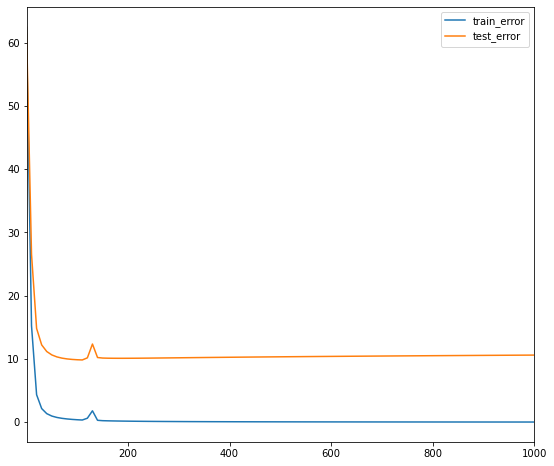

In [680]:
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10)

In [626]:
ratings

,user_id,movie_id,score
0,0,4,10
1,0,5,10
2,0,6,10
3,0,711,10
4,0,729,10
...,...,...,...
20865,157,708,9
20866,157,739,4
20867,157,728,8
20868,157,734,8


In [633]:
ratings.join(users, on='user_id' ,lsuffix='left',rsuffix='r')

,user_idleft,movie_id,score,user_idr,user
0,0,4,10,0,Sade04
1,0,5,10,0,Sade04
2,0,6,10,0,Sade04
3,0,711,10,0,Sade04
4,0,729,10,0,Sade04
...,...,...,...,...,...
20865,157,708,9,157,chocopieeater
20866,157,739,4,157,chocopieeater
20867,157,728,8,157,chocopieeater
20868,157,734,8,157,chocopieeater


In [636]:
buddy.load_anime_details([734])

,id,title,main_picture,start_date,end_date,genres
0,734,Kizuna: Koi no kara Sawagi,{'medium': 'https://api-cdn.myanimelist.net/im...,2001-03-03,2001-03-03,"[Boys Love, Drama, Erotica, Romance]"


In [ ]:
user_ratings = pd.DataFrame(buddy.read_json('user_ratings.json'))
anime = pd.DataFrame(buddy.read_json('animes.json'))

In [ ]:
users = buddy.load_all_users()

In [ ]:
user_df

In [ ]:
user_ratings

In [6]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
    Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [7]:
# @title User recommendations and nearest neighbors (run this cell)
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
    if True:
        scores = compute_scores(
            model.embeddings["user_id"][967], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({t
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
        rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
        df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
    # Search for movie ids that match the given substring.
    ids =  movies[movies['title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['title'].values
    if len(titles) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    print("Nearest neighbors of : %s." % titles[0])
    if len(titles) > 1:
        print("[Found more than one matching movie. Other candidates: {}]".format(
            ", ".join(titles[1:])))
    movie_id = ids[0]
    scores = compute_scores(
        model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
        measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
        })
    display.display(df.sort_values([score_key], ascending=False).head(k))

SyntaxError: invalid syntax (<ipython-input-7-b253c6c8bdbb>, line 8)

In [8]:
user_recommendations(model, measure=COSINE, k=5)

NameError: name 'user_recommendations' is not defined

In [9]:
buddy.load_all_users()

0                Ramun
1            bugeekman
2           pndaneitor
3              tjaym17
4              Ares_25
            ...       
347             nao__o
348              whtmu
349    kikirikimafijas
352             _Sara0
354          javiserey
Length: 45405, dtype: object

In [17]:
anime

,id,title,main_picture,start_date,end_date,genres
0,22199,Akame ga Kill!,{'medium': 'https://api-cdn.myanimelist.net/im...,2014-07-07,2014-12-15,"[Action, Adventure, Drama, Fantasy, Shounen]"
1,32828,Amaama to Inazuma,{'medium': 'https://api-cdn.myanimelist.net/im...,2016-07-05,2016-09-20,"[Comedy, Gourmet, Seinen, Slice of Life]"
2,269,Bleach,{'medium': 'https://api-cdn.myanimelist.net/im...,2004-10-05,2012-03-27,"[Action, Adventure, Comedy, Shounen, Super Pow..."
3,31043,Boku dake ga Inai Machi,{'medium': 'https://api-cdn.myanimelist.net/im...,2016-01-08,2016-03-25,"[Mystery, Psychological, Seinen, Supernatural]"
4,31964,Boku no Hero Academia,{'medium': 'https://api-cdn.myanimelist.net/im...,2016-04-03,2016-06-26,"[Action, Comedy, School, Shounen, Super Power]"
...,...,...,...,...,...,...
349,37779,Yakusoku no Neverland,{'medium': 'https://api-cdn.myanimelist.net/im...,2019-01-10,2019-03-29,"[Horror, Mystery, Psychological, Sci-Fi, Shoun..."
350,39617,Yakusoku no Neverland 2nd Season,{'medium': 'https://api-cdn.myanimelist.net/im...,2021-01-08,2021-03-26,"[Mystery, Psychological, Sci-Fi, Shounen, Susp..."
351,32615,Youjo Senki,{'medium': 'https://api-cdn.myanimelist.net/im...,2017-01-06,2017-03-31,"[Action, Military]"
352,37055,Youjo Senki Movie,{'medium': 'https://api-cdn.myanimelist.net/im...,2019-02-08,2019-02-08,"[Action, Military]"


In [ ]:
def generate_anime_detail(anime_list):
    